In [308]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.cell_types_cache import CellTypesCache
%matplotlib inline

data = np.load('ephys_ss_PCA.npy')

In [309]:
data.shape

(246L, 1000L)

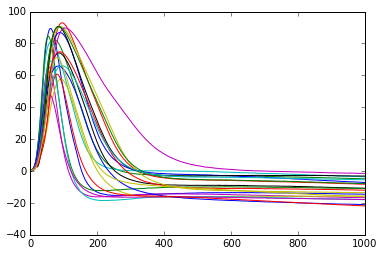

In [310]:
# plot out some traces
r = plt.plot(data[0:200:10,:].T)

In [311]:
# initialized and run decomposition
pca = PCA(20)
pca.fit(data)
decomp = pca.fit_transform(data)
sigma = np.sqrt(pca.explained_variance_)

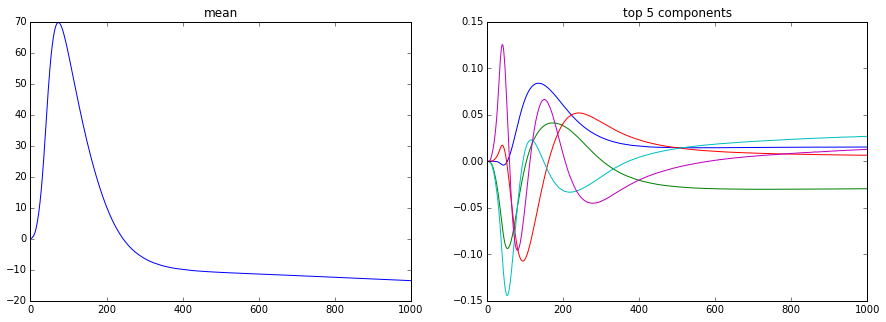

In [312]:
# plot mean and first 5 components
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('mean')
ax2.set_title('top 5 components')
ax1.plot(pca.mean_)
ax2.plot(pca.components_[0:5].T)

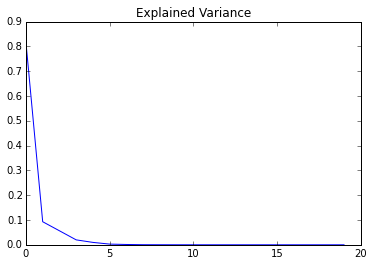

In [346]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained Variance')

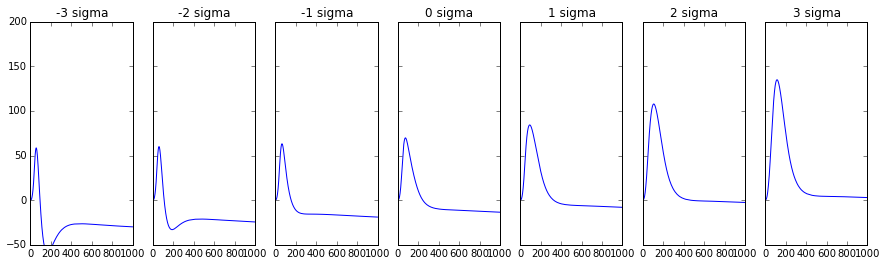

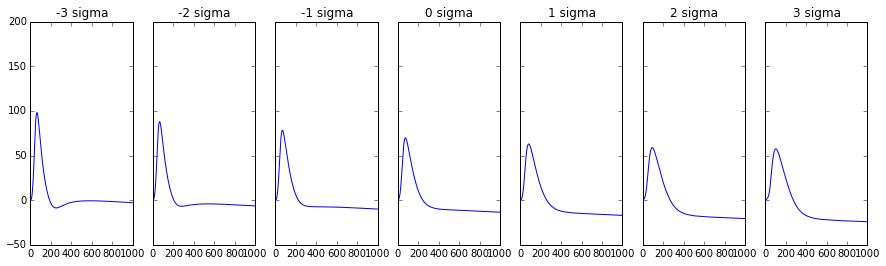

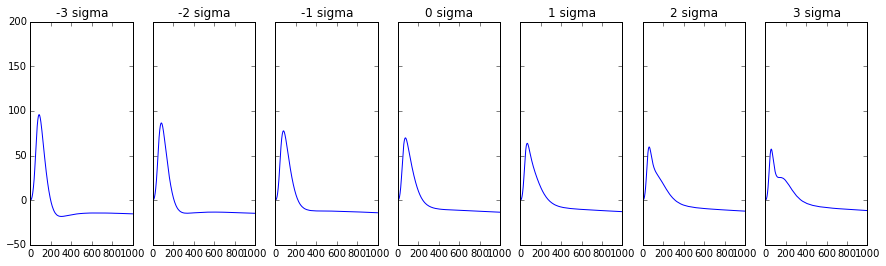

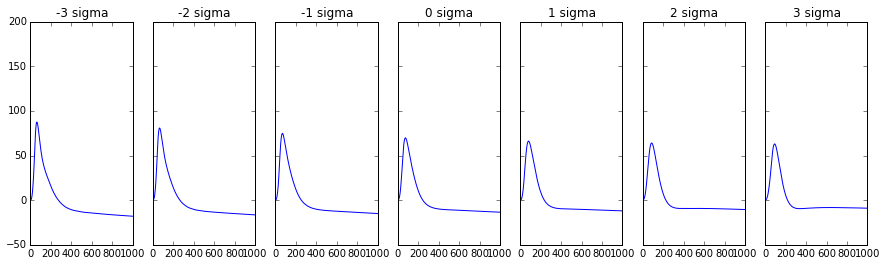

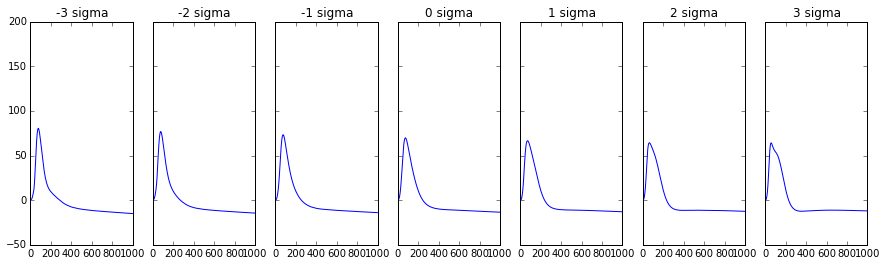

In [377]:
for c in range(5):
    f,ax = plt.subplots(1,7,sharey=True,figsize=(15,4))
    for idx, s in enumerate(range(-3,4)) :
        ax[idx].plot(pca.mean_ + s*sigma[c]*pca.components_[c])
        ax[idx].set_title('%d sigma' % s)
        #ax[idx].set_xlim(0,2600)
        ax[idx].set_ylim(-50,200)
    plt.savefig('ss_components_sigma'+str(c)+'.png')

In [315]:
import pandas as pd

# associate trace data back to specimen_id
trace_df = pd.load('data_frame.h5')
exp_lookup = [e['cell_soma_locations'][0]['specimen_id'] for idx,e in trace_df.iterrows()]

In [349]:
# this dataframe is generated using the "cell_types_dataframe.ipynb" notebook
cells_df = pd.load('cells_dataframe.h5')

In [317]:
# add top pca components to the cells dataframe
ncomp = 10
for c in range(ncomp):
    cells_df['ephys_ss_%02d' % c] = np.nan
    
start_label = 'ephys_ss_%02d' % 0
end_label = 'ephys_ss_%02d' % (ncomp-1)

In [318]:
for idx, e in enumerate(exp_lookup) :
    cells_df.ix[e, start_label:end_label] = np.divide(decomp[idx,0:ncomp],sigma[0:ncomp])

In [319]:
def scatter_with_labels(x,y,label,colors) :
    plt.figure(figsize=(9,9))
    for dtype, color in colors:
        masked = cells_df[cells_df[label] == dtype]
        plt.scatter(masked[x], masked[y], color=color, label=dtype)
    plt.legend(loc='best')
    plt.ylabel(y)
    plt.xlabel(x)
    

In [320]:
trace_df.shape

(246, 37)

In [321]:
def plot_eigen_spike(cx,cy) :
    f,ax = plt.subplots(4,4,sharex=True,sharey=True,figsize=(9,9))
    for idx, x in enumerate(np.linspace(-1.5,1.5,4)) :
        for idy, y in enumerate(np.linspace(1.5,-1.5,4)) :
            ax[idy,idx].plot(pca.mean_ + x*sigma[cx]*pca.components_[cx] + y*sigma[cy]*pca.components_[cy],color='gray')
            ax[idy,idx].set_xlim(0,2600)
            ax[idy,idx].set_ylim(-30,180)
            ax[idy,idx].axes.get_yaxis().set_visible(False)
            ax[idy,idx].axes.get_xaxis().set_visible(False)
            ax[idy,idx].set_frame_on(False)

In [322]:
# map some colors to cre-lines
cre_lines = [
'Rorb-IRES2-Cre',
'Scnn1a-Tg2-Cre',
'Scnn1a-Tg3-Cre',
'Nr5a1-Cre',
'Rbp4-Cre_KL100',
'Ntsr1-Cre',
'Sst-IRES-Cre',
'Pvalb-IRES-Cre',
'Htr3a-Cre_NO152',
'Gad2-IRES-Cre']
cre_colors = [
'darksage',
'green',
'mediumaquamarine',
'c',
'dodgerblue',
'blue',
'magenta',
'firebrick',
'r']

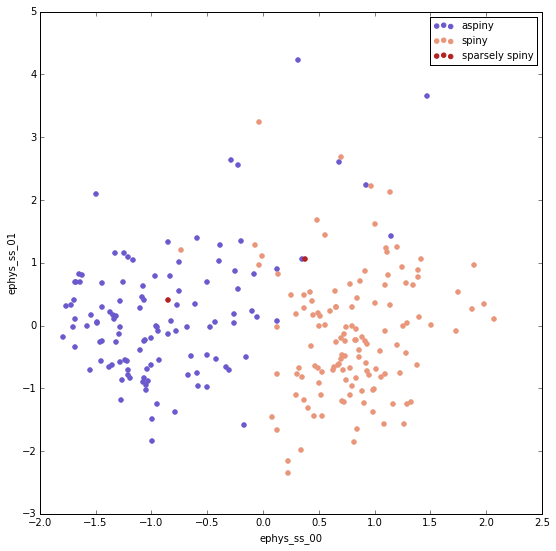

In [323]:
scatter_with_labels('ephys_ss_00','ephys_ss_01','dendrite_type',
                     zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))

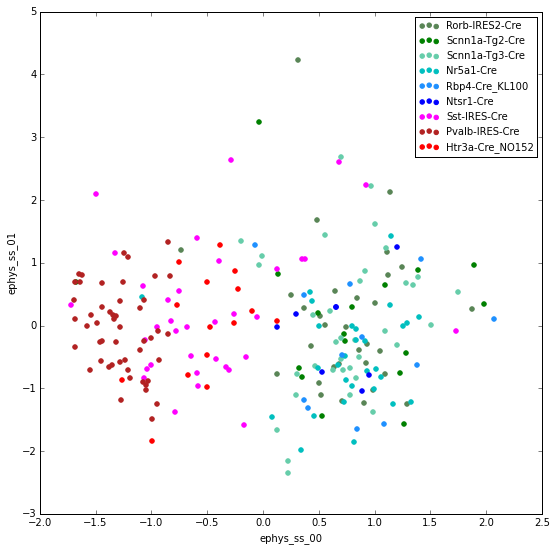

In [324]:
scatter_with_labels('ephys_ss_00','ephys_ss_01','mouse_line', zip(cre_lines,cre_colors))


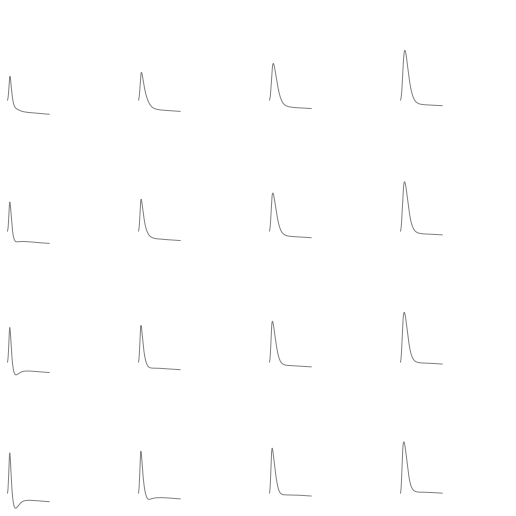

In [325]:
plot_eigen_spike(0,1)

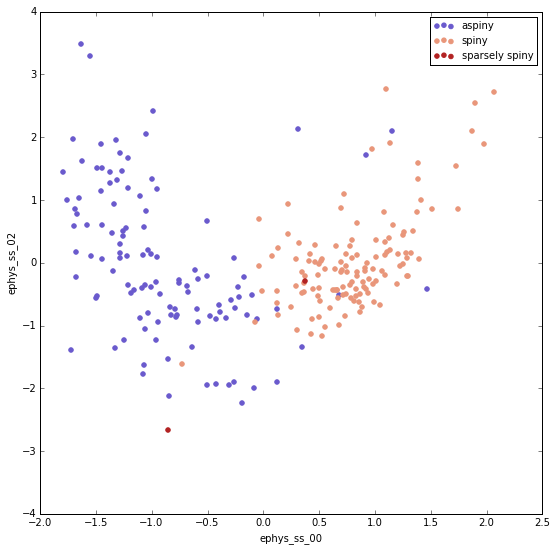

In [326]:
scatter_with_labels('ephys_ss_00','ephys_ss_02','dendrite_type',
                     zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))

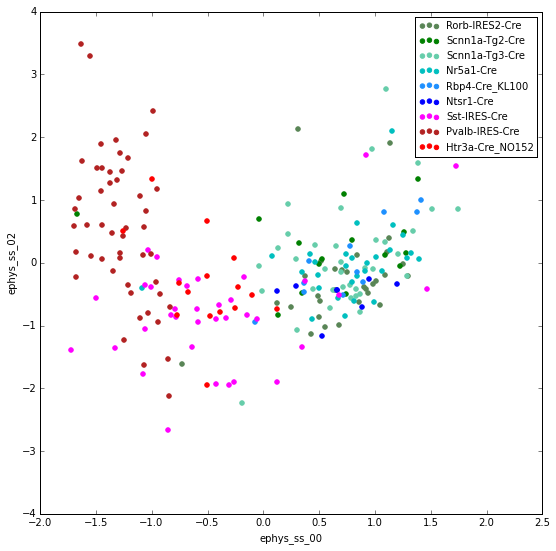

In [327]:
scatter_with_labels('ephys_ss_00','ephys_ss_02','mouse_line', zip(cre_lines,cre_colors))

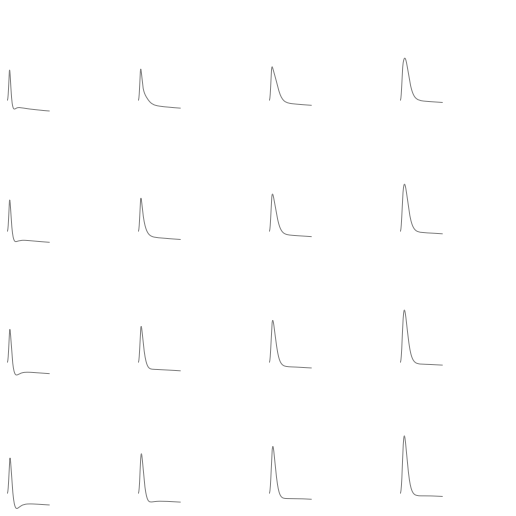

In [328]:
plot_eigen_spike(0,2)

In [329]:
# compute correlation between all columns
correlation = cells_df.corr(method='spearman')

In [330]:
ephys_corr = correlation.ix['tau':'adaptation','ephys_ss_00':'ephys_ss_09']

for c in range(5) :
    f = 'ephys_ss_%02d' % c
    mask = (np.fabs(ephys_corr[f]) > 0.5)
    srt = ephys_corr[mask].sort(f,ascending=False)
    print srt[f]
    print '\n'

upstroke_downstroke_ratio_short_square    0.912499
upstroke_downstroke_ratio_long_square     0.847459
upstroke_downstroke_ratio_ramp            0.806420
peak_v_ramp                               0.775615
peak_v_short_square                       0.760128
fast_trough_v_short_square                0.752830
peak_v_long_square                        0.751420
avg_isi                                   0.684257
fast_trough_v_long_square                 0.665760
tau                                       0.614482
adaptation                                0.605608
fast_trough_v_ramp                        0.596792
latency                                   0.562561
peak_t_short_square                       0.513652
trough_t_ramp                            -0.554509
slow_trough_t_ramp                       -0.554858
fast_trough_t_ramp                       -0.555633
threshold_i_ramp                         -0.555817
threshold_t_ramp                         -0.555978
peak_t_ramp                    

In [331]:
from sklearn.cluster import AffinityPropagation
exp_mask = ~np.isnan(cells_df['ephys_ss_00'])
masked = cells_df[exp_mask]
cluster_input = masked.ix[:,'ephys_ss_00':'ephys_ss_09'].as_matrix()

In [332]:
affinity = AffinityPropagation().fit(cluster_input)

In [333]:
# put labels back into cells_df
cells_df['ephys_ss_cluster'] = np.nan

In [334]:
for a in zip(masked.index,affinity.labels_) :
    cells_df.ix[a[0],'ephys_ss_cluster'] = a[1]

In [335]:
len(np.unique(affinity.labels_))

29

In [336]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

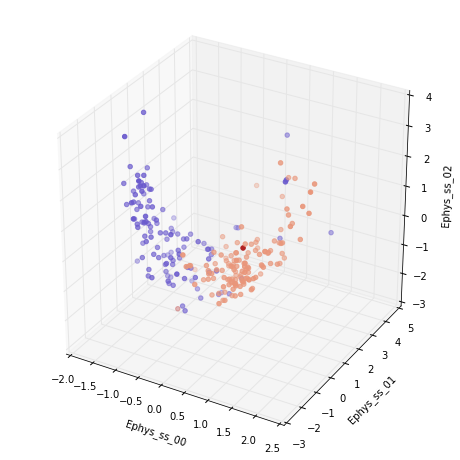

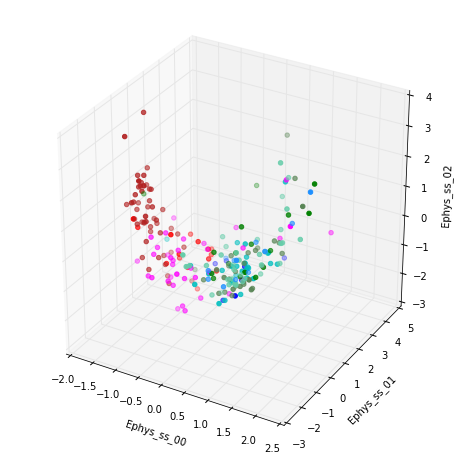

In [357]:
def D_scatter_with_labels(x,y,z,label,colors):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['legend.fontsize'] = 10
    for dtype, color in colors:
        masked = cells_df[cells_df[label] == dtype]
        ax.scatter(masked[x], masked[y], masked[z],color=color, label=dtype)
        
    ax.set_xlabel('Ephys_ss_00')
    ax.set_ylabel('Ephys_ss_01')
    ax.set_zlabel('Ephys_ss_02')

D_scatter_with_labels('ephys_ss_00','ephys_ss_01','ephys_ss_02','dendrite_type',
                     zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))
D_scatter_with_labels('ephys_ss_00','ephys_ss_01','ephys_ss_02','mouse_line', zip(cre_lines,cre_colors))

In [338]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)

In [339]:
model.fit(pca.components_)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [340]:
dummy_var = cells_df.ix[:,'ephys_ss_00':'ephys_ss_09']

In [341]:
model.fit(cluster_input)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [342]:
model.labels_.shape
cells_df.shape

(246, 104)

In [343]:
type(cluster_input)

numpy.ndarray

In [344]:
masked['KMeans_Labels']=model.labels_
cells_df['SS_KMeans_Labels']=model.labels_
cells_df.save('data_frame_cluster.h5')

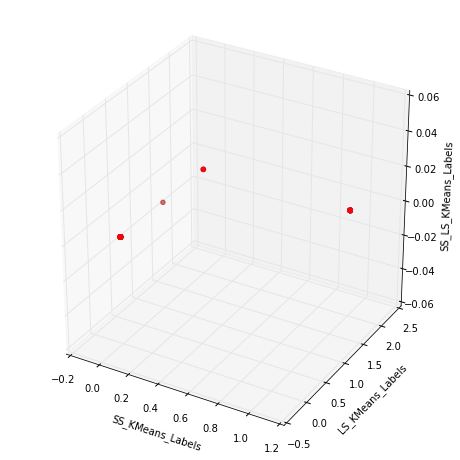

In [359]:
def D_scatter_with_labels(x,y,z,label,colors):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['legend.fontsize'] = 10
    for dtype, color in colors:
        masked = cells_df[cells_df[label] == dtype]
        ax.scatter(masked[x], masked[y], masked[z],color=color, label=dtype)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

#D_scatter_with_labels('ephys_ss_00','ephys_ss_01','ephys_ss_02','dendrite_type',zip(cells_df['dendrite_type'].unique(),['slateblue', 'darksalmon','firebrick']))
D_scatter_with_labels('SS_KMeans_Labels','LS_KMeans_Labels','SS_LS_KMeans_Labels','mouse_line', zip(cre_lines,cre_colors))

In [355]:
cells_df = pd.load('data_frame_cluster.h5')

In [360]:
long_square = np.load('ephys_ls_spike_one.npy')

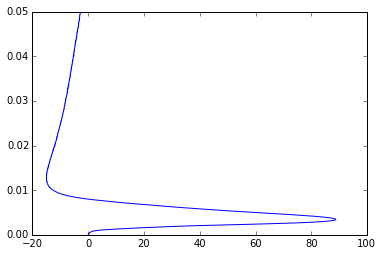

In [362]:
plt.plot(long_square[0],np.arange(0, len(long_square[0])) * (1.0 /20000))

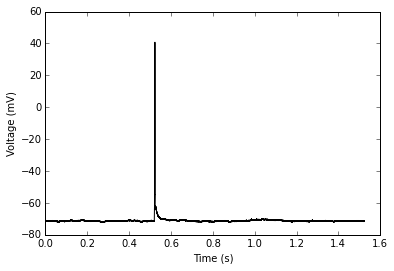

In [374]:
ctc = CellTypesCache(manifest_file='F:\cell_types\manifest.json')
data_set = ctc.get_ephys_data(trace_df['id'].iloc[0])
sweep_data = data_set.get_sweep(20)
v = sweep_data["response"] # in V
v *= 1e3 # to mV
sampling_rate = sweep_data["sampling_rate"] # in Hz
#spike_time=(get_threshold_time(spec_id,sweep_number)[num]*sampling_rate)
v[:] = [x  for x in v]
v=v[100000:450000]
t = np.arange(0, len(v)) * (1.0 / sampling_rate)
plt.plot(t,v,'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

In [373]:
trace_df.keys()

Index([                u'apical',    u'cell_soma_locations',
                    u'data_sets',          u'dendrite_type',
                        u'donor',               u'donor_id',
               u'ephys_features',        u'ephys_result_id',
       u'external_specimen_name',           u'failed_facet',
               u'has_morphology',     u'has_reconstruction',
                   u'hemisphere',                     u'id',
             u'is_cell_specimen',                 u'is_ish',
                         u'name', u'neuron_reconstructions',
                    u'parent_id',         u'parent_x_coord',
               u'parent_y_coord',         u'parent_z_coord',
         u'rna_integrity_number',       u'specimen_id_path',
                u'specimen_tags',              u'sphinx_id',
                    u'structure',           u'structure_id',
                    u'tissue_ph',                 u'weight',
                     u'Cre_Line',                 u'Updown',
                        